## Problem Statement

We have been given a PDE: du/dx=2du/dt+u
and boundary condition: u(x,0)=6e^(-3x)

- Independent variables: x,t (input)
- Dependent variables: u (outputs)


We have to find out u(x,t) for all x in range [0,2] and t in range [0,1]


When we solved this problem analytically, we found the solution: u(x,t) = 6e^(-3x-2t)


Our f is f = du/dx - 2du/dt - u

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
import pandas as pd

In [3]:
# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 2 (x,t)
and #outputs = 1

You can add ass many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 5 hidden layer with 5 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

In [4]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [5]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_x - 2*u_t - u
    return pde

In [6]:
## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc)

In [7]:
### (3) Training / Fitting
iterations = 20000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)
    

0 Traning Loss: tensor(3.2443)
1 Traning Loss: tensor(3.2342)
2 Traning Loss: tensor(3.2241)
3 Traning Loss: tensor(3.2141)
4 Traning Loss: tensor(3.2041)
5 Traning Loss: tensor(3.1943)
6 Traning Loss: tensor(3.1845)
7 Traning Loss: tensor(3.1748)
8 Traning Loss: tensor(3.1651)
9 Traning Loss: tensor(3.1556)
10 Traning Loss: tensor(3.1461)
11 Traning Loss: tensor(3.1367)
12 Traning Loss: tensor(3.1274)
13 Traning Loss: tensor(3.1182)
14 Traning Loss: tensor(3.1090)
15 Traning Loss: tensor(3.0999)
16 Traning Loss: tensor(3.0910)
17 Traning Loss: tensor(3.0821)
18 Traning Loss: tensor(3.0733)
19 Traning Loss: tensor(3.0645)
20 Traning Loss: tensor(3.0559)
21 Traning Loss: tensor(3.0474)
22 Traning Loss: tensor(3.0389)
23 Traning Loss: tensor(3.0305)
24 Traning Loss: tensor(3.0222)
25 Traning Loss: tensor(3.0140)
26 Traning Loss: tensor(3.0059)
27 Traning Loss: tensor(2.9979)
28 Traning Loss: tensor(2.9900)
29 Traning Loss: tensor(2.9821)
30 Traning Loss: tensor(2.9743)
31 Traning Loss: t

274 Traning Loss: tensor(2.5514)
275 Traning Loss: tensor(2.5514)
276 Traning Loss: tensor(2.5514)
277 Traning Loss: tensor(2.5514)
278 Traning Loss: tensor(2.5513)
279 Traning Loss: tensor(2.5513)
280 Traning Loss: tensor(2.5513)
281 Traning Loss: tensor(2.5513)
282 Traning Loss: tensor(2.5513)
283 Traning Loss: tensor(2.5512)
284 Traning Loss: tensor(2.5512)
285 Traning Loss: tensor(2.5512)
286 Traning Loss: tensor(2.5511)
287 Traning Loss: tensor(2.5511)
288 Traning Loss: tensor(2.5511)
289 Traning Loss: tensor(2.5511)
290 Traning Loss: tensor(2.5510)
291 Traning Loss: tensor(2.5510)
292 Traning Loss: tensor(2.5510)
293 Traning Loss: tensor(2.5510)
294 Traning Loss: tensor(2.5509)
295 Traning Loss: tensor(2.5509)
296 Traning Loss: tensor(2.5509)
297 Traning Loss: tensor(2.5509)
298 Traning Loss: tensor(2.5508)
299 Traning Loss: tensor(2.5508)
300 Traning Loss: tensor(2.5508)
301 Traning Loss: tensor(2.5507)
302 Traning Loss: tensor(2.5507)
303 Traning Loss: tensor(2.5507)
304 Tranin

539 Traning Loss: tensor(2.5012)
540 Traning Loss: tensor(2.5008)
541 Traning Loss: tensor(2.5004)
542 Traning Loss: tensor(2.4991)
543 Traning Loss: tensor(2.4989)
544 Traning Loss: tensor(2.4979)
545 Traning Loss: tensor(2.4974)
546 Traning Loss: tensor(2.4963)
547 Traning Loss: tensor(2.4957)
548 Traning Loss: tensor(2.4956)
549 Traning Loss: tensor(2.4947)
550 Traning Loss: tensor(2.4936)
551 Traning Loss: tensor(2.4934)
552 Traning Loss: tensor(2.4921)
553 Traning Loss: tensor(2.4913)
554 Traning Loss: tensor(2.4908)
555 Traning Loss: tensor(2.4903)
556 Traning Loss: tensor(2.4888)
557 Traning Loss: tensor(2.4890)
558 Traning Loss: tensor(2.4872)
559 Traning Loss: tensor(2.4871)
560 Traning Loss: tensor(2.4863)
561 Traning Loss: tensor(2.4851)
562 Traning Loss: tensor(2.4848)
563 Traning Loss: tensor(2.4838)
564 Traning Loss: tensor(2.4828)
565 Traning Loss: tensor(2.4823)
566 Traning Loss: tensor(2.4814)
567 Traning Loss: tensor(2.4808)
568 Traning Loss: tensor(2.4796)
569 Tranin

803 Traning Loss: tensor(2.0714)
804 Traning Loss: tensor(2.0610)
805 Traning Loss: tensor(2.0624)
806 Traning Loss: tensor(2.0661)
807 Traning Loss: tensor(2.0665)
808 Traning Loss: tensor(2.0561)
809 Traning Loss: tensor(2.0574)
810 Traning Loss: tensor(2.0619)
811 Traning Loss: tensor(2.0582)
812 Traning Loss: tensor(2.0536)
813 Traning Loss: tensor(2.0525)
814 Traning Loss: tensor(2.0466)
815 Traning Loss: tensor(2.0408)
816 Traning Loss: tensor(2.0409)
817 Traning Loss: tensor(2.0473)
818 Traning Loss: tensor(2.0424)
819 Traning Loss: tensor(2.0386)
820 Traning Loss: tensor(2.0393)
821 Traning Loss: tensor(2.0354)
822 Traning Loss: tensor(2.0344)
823 Traning Loss: tensor(2.0333)
824 Traning Loss: tensor(2.0327)
825 Traning Loss: tensor(2.0190)
826 Traning Loss: tensor(2.0173)
827 Traning Loss: tensor(2.0147)
828 Traning Loss: tensor(2.0170)
829 Traning Loss: tensor(2.0131)
830 Traning Loss: tensor(2.0212)
831 Traning Loss: tensor(2.0182)
832 Traning Loss: tensor(2.0157)
833 Tranin

1055 Traning Loss: tensor(1.2962)
1056 Traning Loss: tensor(1.2857)
1057 Traning Loss: tensor(1.2864)
1058 Traning Loss: tensor(1.2856)
1059 Traning Loss: tensor(1.2877)
1060 Traning Loss: tensor(1.2660)
1061 Traning Loss: tensor(1.2738)
1062 Traning Loss: tensor(1.2733)
1063 Traning Loss: tensor(1.2551)
1064 Traning Loss: tensor(1.2446)
1065 Traning Loss: tensor(1.2543)
1066 Traning Loss: tensor(1.2366)
1067 Traning Loss: tensor(1.2487)
1068 Traning Loss: tensor(1.2368)
1069 Traning Loss: tensor(1.2371)
1070 Traning Loss: tensor(1.2332)
1071 Traning Loss: tensor(1.2206)
1072 Traning Loss: tensor(1.2100)
1073 Traning Loss: tensor(1.2097)
1074 Traning Loss: tensor(1.2026)
1075 Traning Loss: tensor(1.2041)
1076 Traning Loss: tensor(1.1891)
1077 Traning Loss: tensor(1.1866)
1078 Traning Loss: tensor(1.1882)
1079 Traning Loss: tensor(1.1722)
1080 Traning Loss: tensor(1.1827)
1081 Traning Loss: tensor(1.1848)
1082 Traning Loss: tensor(1.1612)
1083 Traning Loss: tensor(1.1651)
1084 Traning L

1314 Traning Loss: tensor(0.4805)
1315 Traning Loss: tensor(0.4614)
1316 Traning Loss: tensor(0.4961)
1317 Traning Loss: tensor(0.4868)
1318 Traning Loss: tensor(0.4836)
1319 Traning Loss: tensor(0.4670)
1320 Traning Loss: tensor(0.4720)
1321 Traning Loss: tensor(0.5438)
1322 Traning Loss: tensor(0.4561)
1323 Traning Loss: tensor(0.4561)
1324 Traning Loss: tensor(0.4190)
1325 Traning Loss: tensor(0.4961)
1326 Traning Loss: tensor(0.4523)
1327 Traning Loss: tensor(0.4833)
1328 Traning Loss: tensor(0.4179)
1329 Traning Loss: tensor(0.4556)
1330 Traning Loss: tensor(0.4934)
1331 Traning Loss: tensor(0.4516)
1332 Traning Loss: tensor(0.4172)
1333 Traning Loss: tensor(0.4310)
1334 Traning Loss: tensor(0.4378)
1335 Traning Loss: tensor(0.4567)
1336 Traning Loss: tensor(0.4368)
1337 Traning Loss: tensor(0.4567)
1338 Traning Loss: tensor(0.4620)
1339 Traning Loss: tensor(0.4670)
1340 Traning Loss: tensor(0.4278)
1341 Traning Loss: tensor(0.4547)
1342 Traning Loss: tensor(0.4492)
1343 Traning L

1576 Traning Loss: tensor(0.2186)
1577 Traning Loss: tensor(0.2250)
1578 Traning Loss: tensor(0.2746)
1579 Traning Loss: tensor(0.2346)
1580 Traning Loss: tensor(0.2730)
1581 Traning Loss: tensor(0.2401)
1582 Traning Loss: tensor(0.1804)
1583 Traning Loss: tensor(0.2266)
1584 Traning Loss: tensor(0.2521)
1585 Traning Loss: tensor(0.2694)
1586 Traning Loss: tensor(0.2379)
1587 Traning Loss: tensor(0.2526)
1588 Traning Loss: tensor(0.2426)
1589 Traning Loss: tensor(0.2155)
1590 Traning Loss: tensor(0.2276)
1591 Traning Loss: tensor(0.2212)
1592 Traning Loss: tensor(0.2175)
1593 Traning Loss: tensor(0.2005)
1594 Traning Loss: tensor(0.2524)
1595 Traning Loss: tensor(0.2125)
1596 Traning Loss: tensor(0.2197)
1597 Traning Loss: tensor(0.2084)
1598 Traning Loss: tensor(0.2547)
1599 Traning Loss: tensor(0.2287)
1600 Traning Loss: tensor(0.1884)
1601 Traning Loss: tensor(0.1942)
1602 Traning Loss: tensor(0.2812)
1603 Traning Loss: tensor(0.2168)
1604 Traning Loss: tensor(0.2258)
1605 Traning L

1841 Traning Loss: tensor(0.1156)
1842 Traning Loss: tensor(0.1232)
1843 Traning Loss: tensor(0.1614)
1844 Traning Loss: tensor(0.1388)
1845 Traning Loss: tensor(0.1564)
1846 Traning Loss: tensor(0.1461)
1847 Traning Loss: tensor(0.1422)
1848 Traning Loss: tensor(0.1616)
1849 Traning Loss: tensor(0.1516)
1850 Traning Loss: tensor(0.1709)
1851 Traning Loss: tensor(0.1099)
1852 Traning Loss: tensor(0.1469)
1853 Traning Loss: tensor(0.1617)
1854 Traning Loss: tensor(0.1446)
1855 Traning Loss: tensor(0.1191)
1856 Traning Loss: tensor(0.1631)
1857 Traning Loss: tensor(0.1224)
1858 Traning Loss: tensor(0.1406)
1859 Traning Loss: tensor(0.1303)
1860 Traning Loss: tensor(0.1253)
1861 Traning Loss: tensor(0.1663)
1862 Traning Loss: tensor(0.1422)
1863 Traning Loss: tensor(0.1695)
1864 Traning Loss: tensor(0.1262)
1865 Traning Loss: tensor(0.1471)
1866 Traning Loss: tensor(0.1282)
1867 Traning Loss: tensor(0.1264)
1868 Traning Loss: tensor(0.1351)
1869 Traning Loss: tensor(0.1174)
1870 Traning L

2117 Traning Loss: tensor(0.0784)
2118 Traning Loss: tensor(0.0739)
2119 Traning Loss: tensor(0.1182)
2120 Traning Loss: tensor(0.0697)
2121 Traning Loss: tensor(0.0989)
2122 Traning Loss: tensor(0.0884)
2123 Traning Loss: tensor(0.1085)
2124 Traning Loss: tensor(0.0730)
2125 Traning Loss: tensor(0.1170)
2126 Traning Loss: tensor(0.1380)
2127 Traning Loss: tensor(0.0899)
2128 Traning Loss: tensor(0.0943)
2129 Traning Loss: tensor(0.0802)
2130 Traning Loss: tensor(0.0725)
2131 Traning Loss: tensor(0.0682)
2132 Traning Loss: tensor(0.1078)
2133 Traning Loss: tensor(0.0771)
2134 Traning Loss: tensor(0.0971)
2135 Traning Loss: tensor(0.1330)
2136 Traning Loss: tensor(0.0893)
2137 Traning Loss: tensor(0.0661)
2138 Traning Loss: tensor(0.0885)
2139 Traning Loss: tensor(0.0950)
2140 Traning Loss: tensor(0.1052)
2141 Traning Loss: tensor(0.0720)
2142 Traning Loss: tensor(0.0966)
2143 Traning Loss: tensor(0.0966)
2144 Traning Loss: tensor(0.0790)
2145 Traning Loss: tensor(0.0787)
2146 Traning L

2384 Traning Loss: tensor(0.0585)
2385 Traning Loss: tensor(0.0835)
2386 Traning Loss: tensor(0.0820)
2387 Traning Loss: tensor(0.0484)
2388 Traning Loss: tensor(0.0531)
2389 Traning Loss: tensor(0.0675)
2390 Traning Loss: tensor(0.0656)
2391 Traning Loss: tensor(0.0594)
2392 Traning Loss: tensor(0.0704)
2393 Traning Loss: tensor(0.0632)
2394 Traning Loss: tensor(0.0529)
2395 Traning Loss: tensor(0.0521)
2396 Traning Loss: tensor(0.0540)
2397 Traning Loss: tensor(0.0647)
2398 Traning Loss: tensor(0.0471)
2399 Traning Loss: tensor(0.0623)
2400 Traning Loss: tensor(0.0947)
2401 Traning Loss: tensor(0.0583)
2402 Traning Loss: tensor(0.0564)
2403 Traning Loss: tensor(0.0583)
2404 Traning Loss: tensor(0.0452)
2405 Traning Loss: tensor(0.0668)
2406 Traning Loss: tensor(0.0890)
2407 Traning Loss: tensor(0.0709)
2408 Traning Loss: tensor(0.0510)
2409 Traning Loss: tensor(0.0520)
2410 Traning Loss: tensor(0.0591)
2411 Traning Loss: tensor(0.0532)
2412 Traning Loss: tensor(0.0588)
2413 Traning L

2642 Traning Loss: tensor(0.0541)
2643 Traning Loss: tensor(0.0457)
2644 Traning Loss: tensor(0.0547)
2645 Traning Loss: tensor(0.0529)
2646 Traning Loss: tensor(0.0371)
2647 Traning Loss: tensor(0.0382)
2648 Traning Loss: tensor(0.0330)
2649 Traning Loss: tensor(0.0351)
2650 Traning Loss: tensor(0.0440)
2651 Traning Loss: tensor(0.0417)
2652 Traning Loss: tensor(0.0442)
2653 Traning Loss: tensor(0.0359)
2654 Traning Loss: tensor(0.0419)
2655 Traning Loss: tensor(0.0460)
2656 Traning Loss: tensor(0.0460)
2657 Traning Loss: tensor(0.0609)
2658 Traning Loss: tensor(0.0606)
2659 Traning Loss: tensor(0.0724)
2660 Traning Loss: tensor(0.0496)
2661 Traning Loss: tensor(0.0367)
2662 Traning Loss: tensor(0.0553)
2663 Traning Loss: tensor(0.0558)
2664 Traning Loss: tensor(0.0558)
2665 Traning Loss: tensor(0.0478)
2666 Traning Loss: tensor(0.0421)
2667 Traning Loss: tensor(0.0455)
2668 Traning Loss: tensor(0.0398)
2669 Traning Loss: tensor(0.0573)
2670 Traning Loss: tensor(0.0406)
2671 Traning L

2883 Traning Loss: tensor(0.0430)
2884 Traning Loss: tensor(0.0442)
2885 Traning Loss: tensor(0.0357)
2886 Traning Loss: tensor(0.0305)
2887 Traning Loss: tensor(0.0342)
2888 Traning Loss: tensor(0.0363)
2889 Traning Loss: tensor(0.0441)
2890 Traning Loss: tensor(0.0354)
2891 Traning Loss: tensor(0.0382)
2892 Traning Loss: tensor(0.0409)
2893 Traning Loss: tensor(0.0282)
2894 Traning Loss: tensor(0.0347)
2895 Traning Loss: tensor(0.0301)
2896 Traning Loss: tensor(0.0450)
2897 Traning Loss: tensor(0.0338)
2898 Traning Loss: tensor(0.0293)
2899 Traning Loss: tensor(0.0302)
2900 Traning Loss: tensor(0.0363)
2901 Traning Loss: tensor(0.0357)
2902 Traning Loss: tensor(0.0356)
2903 Traning Loss: tensor(0.0328)
2904 Traning Loss: tensor(0.0351)
2905 Traning Loss: tensor(0.0628)
2906 Traning Loss: tensor(0.0345)
2907 Traning Loss: tensor(0.0323)
2908 Traning Loss: tensor(0.0332)
2909 Traning Loss: tensor(0.0285)
2910 Traning Loss: tensor(0.0396)
2911 Traning Loss: tensor(0.0355)
2912 Traning L

3152 Traning Loss: tensor(0.0220)
3153 Traning Loss: tensor(0.0271)
3154 Traning Loss: tensor(0.0318)
3155 Traning Loss: tensor(0.0426)
3156 Traning Loss: tensor(0.0387)
3157 Traning Loss: tensor(0.0330)
3158 Traning Loss: tensor(0.0253)
3159 Traning Loss: tensor(0.0299)
3160 Traning Loss: tensor(0.0245)
3161 Traning Loss: tensor(0.0399)
3162 Traning Loss: tensor(0.0264)
3163 Traning Loss: tensor(0.0303)
3164 Traning Loss: tensor(0.0409)
3165 Traning Loss: tensor(0.0265)
3166 Traning Loss: tensor(0.0248)
3167 Traning Loss: tensor(0.0405)
3168 Traning Loss: tensor(0.0297)
3169 Traning Loss: tensor(0.0454)
3170 Traning Loss: tensor(0.0276)
3171 Traning Loss: tensor(0.0266)
3172 Traning Loss: tensor(0.0287)
3173 Traning Loss: tensor(0.0263)
3174 Traning Loss: tensor(0.0301)
3175 Traning Loss: tensor(0.0245)
3176 Traning Loss: tensor(0.0217)
3177 Traning Loss: tensor(0.0314)
3178 Traning Loss: tensor(0.0214)
3179 Traning Loss: tensor(0.0333)
3180 Traning Loss: tensor(0.0258)
3181 Traning L

3402 Traning Loss: tensor(0.0191)
3403 Traning Loss: tensor(0.0226)
3404 Traning Loss: tensor(0.0210)
3405 Traning Loss: tensor(0.0214)
3406 Traning Loss: tensor(0.0285)
3407 Traning Loss: tensor(0.0247)
3408 Traning Loss: tensor(0.0240)
3409 Traning Loss: tensor(0.0174)
3410 Traning Loss: tensor(0.0183)
3411 Traning Loss: tensor(0.0236)
3412 Traning Loss: tensor(0.0238)
3413 Traning Loss: tensor(0.0572)
3414 Traning Loss: tensor(0.0226)
3415 Traning Loss: tensor(0.0241)
3416 Traning Loss: tensor(0.0238)
3417 Traning Loss: tensor(0.0174)
3418 Traning Loss: tensor(0.0198)
3419 Traning Loss: tensor(0.0194)
3420 Traning Loss: tensor(0.0235)
3421 Traning Loss: tensor(0.0218)
3422 Traning Loss: tensor(0.0266)
3423 Traning Loss: tensor(0.0243)
3424 Traning Loss: tensor(0.0205)
3425 Traning Loss: tensor(0.0234)
3426 Traning Loss: tensor(0.0175)
3427 Traning Loss: tensor(0.0241)
3428 Traning Loss: tensor(0.0244)
3429 Traning Loss: tensor(0.0273)
3430 Traning Loss: tensor(0.0190)
3431 Traning L

3671 Traning Loss: tensor(0.0210)
3672 Traning Loss: tensor(0.0160)
3673 Traning Loss: tensor(0.0156)
3674 Traning Loss: tensor(0.0179)
3675 Traning Loss: tensor(0.0477)
3676 Traning Loss: tensor(0.0206)
3677 Traning Loss: tensor(0.0152)
3678 Traning Loss: tensor(0.0184)
3679 Traning Loss: tensor(0.0236)
3680 Traning Loss: tensor(0.0184)
3681 Traning Loss: tensor(0.0138)
3682 Traning Loss: tensor(0.0169)
3683 Traning Loss: tensor(0.0144)
3684 Traning Loss: tensor(0.0300)
3685 Traning Loss: tensor(0.0346)
3686 Traning Loss: tensor(0.0211)
3687 Traning Loss: tensor(0.0278)
3688 Traning Loss: tensor(0.0163)
3689 Traning Loss: tensor(0.0187)
3690 Traning Loss: tensor(0.0241)
3691 Traning Loss: tensor(0.0265)
3692 Traning Loss: tensor(0.0267)
3693 Traning Loss: tensor(0.0221)
3694 Traning Loss: tensor(0.0178)
3695 Traning Loss: tensor(0.0172)
3696 Traning Loss: tensor(0.0178)
3697 Traning Loss: tensor(0.0211)
3698 Traning Loss: tensor(0.0196)
3699 Traning Loss: tensor(0.0296)
3700 Traning L

3927 Traning Loss: tensor(0.0141)
3928 Traning Loss: tensor(0.0190)
3929 Traning Loss: tensor(0.0142)
3930 Traning Loss: tensor(0.0135)
3931 Traning Loss: tensor(0.0139)
3932 Traning Loss: tensor(0.0160)
3933 Traning Loss: tensor(0.0206)
3934 Traning Loss: tensor(0.0207)
3935 Traning Loss: tensor(0.0129)
3936 Traning Loss: tensor(0.0107)
3937 Traning Loss: tensor(0.0224)
3938 Traning Loss: tensor(0.0230)
3939 Traning Loss: tensor(0.0143)
3940 Traning Loss: tensor(0.0190)
3941 Traning Loss: tensor(0.0222)
3942 Traning Loss: tensor(0.0191)
3943 Traning Loss: tensor(0.0148)
3944 Traning Loss: tensor(0.0131)
3945 Traning Loss: tensor(0.0192)
3946 Traning Loss: tensor(0.0181)
3947 Traning Loss: tensor(0.0169)
3948 Traning Loss: tensor(0.0194)
3949 Traning Loss: tensor(0.0191)
3950 Traning Loss: tensor(0.0122)
3951 Traning Loss: tensor(0.0199)
3952 Traning Loss: tensor(0.0168)
3953 Traning Loss: tensor(0.0230)
3954 Traning Loss: tensor(0.0121)
3955 Traning Loss: tensor(0.0166)
3956 Traning L

4192 Traning Loss: tensor(0.0145)
4193 Traning Loss: tensor(0.0152)
4194 Traning Loss: tensor(0.0201)
4195 Traning Loss: tensor(0.0147)
4196 Traning Loss: tensor(0.0112)
4197 Traning Loss: tensor(0.0165)
4198 Traning Loss: tensor(0.0181)
4199 Traning Loss: tensor(0.0116)
4200 Traning Loss: tensor(0.0098)
4201 Traning Loss: tensor(0.0146)
4202 Traning Loss: tensor(0.0096)
4203 Traning Loss: tensor(0.0119)
4204 Traning Loss: tensor(0.0172)
4205 Traning Loss: tensor(0.0151)
4206 Traning Loss: tensor(0.0167)
4207 Traning Loss: tensor(0.0159)
4208 Traning Loss: tensor(0.0180)
4209 Traning Loss: tensor(0.0139)
4210 Traning Loss: tensor(0.0174)
4211 Traning Loss: tensor(0.0107)
4212 Traning Loss: tensor(0.0215)
4213 Traning Loss: tensor(0.0148)
4214 Traning Loss: tensor(0.0102)
4215 Traning Loss: tensor(0.0116)
4216 Traning Loss: tensor(0.0119)
4217 Traning Loss: tensor(0.0107)
4218 Traning Loss: tensor(0.0147)
4219 Traning Loss: tensor(0.0174)
4220 Traning Loss: tensor(0.0245)
4221 Traning L

4445 Traning Loss: tensor(0.0106)
4446 Traning Loss: tensor(0.0097)
4447 Traning Loss: tensor(0.0128)
4448 Traning Loss: tensor(0.0097)
4449 Traning Loss: tensor(0.0106)
4450 Traning Loss: tensor(0.0178)
4451 Traning Loss: tensor(0.0094)
4452 Traning Loss: tensor(0.0100)
4453 Traning Loss: tensor(0.0100)
4454 Traning Loss: tensor(0.0082)
4455 Traning Loss: tensor(0.0112)
4456 Traning Loss: tensor(0.0086)
4457 Traning Loss: tensor(0.0104)
4458 Traning Loss: tensor(0.0110)
4459 Traning Loss: tensor(0.0147)
4460 Traning Loss: tensor(0.0117)
4461 Traning Loss: tensor(0.0119)
4462 Traning Loss: tensor(0.0180)
4463 Traning Loss: tensor(0.0119)
4464 Traning Loss: tensor(0.0088)
4465 Traning Loss: tensor(0.0089)
4466 Traning Loss: tensor(0.0148)
4467 Traning Loss: tensor(0.0162)
4468 Traning Loss: tensor(0.0184)
4469 Traning Loss: tensor(0.0119)
4470 Traning Loss: tensor(0.0108)
4471 Traning Loss: tensor(0.0088)
4472 Traning Loss: tensor(0.0179)
4473 Traning Loss: tensor(0.0106)
4474 Traning L

4704 Traning Loss: tensor(0.0143)
4705 Traning Loss: tensor(0.0102)
4706 Traning Loss: tensor(0.0117)
4707 Traning Loss: tensor(0.0152)
4708 Traning Loss: tensor(0.0076)
4709 Traning Loss: tensor(0.0082)
4710 Traning Loss: tensor(0.0128)
4711 Traning Loss: tensor(0.0096)
4712 Traning Loss: tensor(0.0094)
4713 Traning Loss: tensor(0.0122)
4714 Traning Loss: tensor(0.0102)
4715 Traning Loss: tensor(0.0117)
4716 Traning Loss: tensor(0.0200)
4717 Traning Loss: tensor(0.0085)
4718 Traning Loss: tensor(0.0069)
4719 Traning Loss: tensor(0.0085)
4720 Traning Loss: tensor(0.0078)
4721 Traning Loss: tensor(0.0089)
4722 Traning Loss: tensor(0.0084)
4723 Traning Loss: tensor(0.0106)
4724 Traning Loss: tensor(0.0302)
4725 Traning Loss: tensor(0.0107)
4726 Traning Loss: tensor(0.0201)
4727 Traning Loss: tensor(0.0158)
4728 Traning Loss: tensor(0.0081)
4729 Traning Loss: tensor(0.0175)
4730 Traning Loss: tensor(0.0110)
4731 Traning Loss: tensor(0.0103)
4732 Traning Loss: tensor(0.0076)
4733 Traning L

4968 Traning Loss: tensor(0.0104)
4969 Traning Loss: tensor(0.0157)
4970 Traning Loss: tensor(0.0100)
4971 Traning Loss: tensor(0.0095)
4972 Traning Loss: tensor(0.0093)
4973 Traning Loss: tensor(0.0107)
4974 Traning Loss: tensor(0.0076)
4975 Traning Loss: tensor(0.0089)
4976 Traning Loss: tensor(0.0083)
4977 Traning Loss: tensor(0.0088)
4978 Traning Loss: tensor(0.0091)
4979 Traning Loss: tensor(0.0103)
4980 Traning Loss: tensor(0.0075)
4981 Traning Loss: tensor(0.0066)
4982 Traning Loss: tensor(0.0089)
4983 Traning Loss: tensor(0.0126)
4984 Traning Loss: tensor(0.0083)
4985 Traning Loss: tensor(0.0119)
4986 Traning Loss: tensor(0.0094)
4987 Traning Loss: tensor(0.0076)
4988 Traning Loss: tensor(0.0096)
4989 Traning Loss: tensor(0.0069)
4990 Traning Loss: tensor(0.0145)
4991 Traning Loss: tensor(0.0121)
4992 Traning Loss: tensor(0.0065)
4993 Traning Loss: tensor(0.0113)
4994 Traning Loss: tensor(0.0073)
4995 Traning Loss: tensor(0.0087)
4996 Traning Loss: tensor(0.0092)
4997 Traning L

5241 Traning Loss: tensor(0.0081)
5242 Traning Loss: tensor(0.0068)
5243 Traning Loss: tensor(0.0066)
5244 Traning Loss: tensor(0.0066)
5245 Traning Loss: tensor(0.0136)
5246 Traning Loss: tensor(0.0066)
5247 Traning Loss: tensor(0.0164)
5248 Traning Loss: tensor(0.0074)
5249 Traning Loss: tensor(0.0126)
5250 Traning Loss: tensor(0.0091)
5251 Traning Loss: tensor(0.0077)
5252 Traning Loss: tensor(0.0128)
5253 Traning Loss: tensor(0.0104)
5254 Traning Loss: tensor(0.0071)
5255 Traning Loss: tensor(0.0126)
5256 Traning Loss: tensor(0.0062)
5257 Traning Loss: tensor(0.0070)
5258 Traning Loss: tensor(0.0096)
5259 Traning Loss: tensor(0.0056)
5260 Traning Loss: tensor(0.0067)
5261 Traning Loss: tensor(0.0094)
5262 Traning Loss: tensor(0.0073)
5263 Traning Loss: tensor(0.0078)
5264 Traning Loss: tensor(0.0102)
5265 Traning Loss: tensor(0.0098)
5266 Traning Loss: tensor(0.0057)
5267 Traning Loss: tensor(0.0079)
5268 Traning Loss: tensor(0.0061)
5269 Traning Loss: tensor(0.0106)
5270 Traning L

5509 Traning Loss: tensor(0.0046)
5510 Traning Loss: tensor(0.0135)
5511 Traning Loss: tensor(0.0049)
5512 Traning Loss: tensor(0.0068)
5513 Traning Loss: tensor(0.0074)
5514 Traning Loss: tensor(0.0096)
5515 Traning Loss: tensor(0.0058)
5516 Traning Loss: tensor(0.0104)
5517 Traning Loss: tensor(0.0050)
5518 Traning Loss: tensor(0.0120)
5519 Traning Loss: tensor(0.0069)
5520 Traning Loss: tensor(0.0091)
5521 Traning Loss: tensor(0.0063)
5522 Traning Loss: tensor(0.0102)
5523 Traning Loss: tensor(0.0051)
5524 Traning Loss: tensor(0.0103)
5525 Traning Loss: tensor(0.0049)
5526 Traning Loss: tensor(0.0085)
5527 Traning Loss: tensor(0.0061)
5528 Traning Loss: tensor(0.0084)
5529 Traning Loss: tensor(0.0059)
5530 Traning Loss: tensor(0.0064)
5531 Traning Loss: tensor(0.0089)
5532 Traning Loss: tensor(0.0085)
5533 Traning Loss: tensor(0.0078)
5534 Traning Loss: tensor(0.0057)
5535 Traning Loss: tensor(0.0050)
5536 Traning Loss: tensor(0.0053)
5537 Traning Loss: tensor(0.0105)
5538 Traning L

5769 Traning Loss: tensor(0.0042)
5770 Traning Loss: tensor(0.0047)
5771 Traning Loss: tensor(0.0073)
5772 Traning Loss: tensor(0.0086)
5773 Traning Loss: tensor(0.0049)
5774 Traning Loss: tensor(0.0067)
5775 Traning Loss: tensor(0.0068)
5776 Traning Loss: tensor(0.0062)
5777 Traning Loss: tensor(0.0051)
5778 Traning Loss: tensor(0.0050)
5779 Traning Loss: tensor(0.0064)
5780 Traning Loss: tensor(0.0084)
5781 Traning Loss: tensor(0.0048)
5782 Traning Loss: tensor(0.0078)
5783 Traning Loss: tensor(0.0070)
5784 Traning Loss: tensor(0.0052)
5785 Traning Loss: tensor(0.0065)
5786 Traning Loss: tensor(0.0093)
5787 Traning Loss: tensor(0.0065)
5788 Traning Loss: tensor(0.0047)
5789 Traning Loss: tensor(0.0097)
5790 Traning Loss: tensor(0.0049)
5791 Traning Loss: tensor(0.0072)
5792 Traning Loss: tensor(0.0108)
5793 Traning Loss: tensor(0.0044)
5794 Traning Loss: tensor(0.0079)
5795 Traning Loss: tensor(0.0043)
5796 Traning Loss: tensor(0.0046)
5797 Traning Loss: tensor(0.0046)
5798 Traning L

6029 Traning Loss: tensor(0.0047)
6030 Traning Loss: tensor(0.0055)
6031 Traning Loss: tensor(0.0045)
6032 Traning Loss: tensor(0.0039)
6033 Traning Loss: tensor(0.0040)
6034 Traning Loss: tensor(0.0050)
6035 Traning Loss: tensor(0.0044)
6036 Traning Loss: tensor(0.0071)
6037 Traning Loss: tensor(0.0041)
6038 Traning Loss: tensor(0.0052)
6039 Traning Loss: tensor(0.0050)
6040 Traning Loss: tensor(0.0062)
6041 Traning Loss: tensor(0.0045)
6042 Traning Loss: tensor(0.0038)
6043 Traning Loss: tensor(0.0037)
6044 Traning Loss: tensor(0.0035)
6045 Traning Loss: tensor(0.0059)
6046 Traning Loss: tensor(0.0071)
6047 Traning Loss: tensor(0.0070)
6048 Traning Loss: tensor(0.0035)
6049 Traning Loss: tensor(0.0035)
6050 Traning Loss: tensor(0.0047)
6051 Traning Loss: tensor(0.0060)
6052 Traning Loss: tensor(0.0082)
6053 Traning Loss: tensor(0.0058)
6054 Traning Loss: tensor(0.0042)
6055 Traning Loss: tensor(0.0056)
6056 Traning Loss: tensor(0.0068)
6057 Traning Loss: tensor(0.0050)
6058 Traning L

6289 Traning Loss: tensor(0.0036)
6290 Traning Loss: tensor(0.0037)
6291 Traning Loss: tensor(0.0031)
6292 Traning Loss: tensor(0.0051)
6293 Traning Loss: tensor(0.0049)
6294 Traning Loss: tensor(0.0034)
6295 Traning Loss: tensor(0.0042)
6296 Traning Loss: tensor(0.0060)
6297 Traning Loss: tensor(0.0039)
6298 Traning Loss: tensor(0.0056)
6299 Traning Loss: tensor(0.0046)
6300 Traning Loss: tensor(0.0038)
6301 Traning Loss: tensor(0.0064)
6302 Traning Loss: tensor(0.0045)
6303 Traning Loss: tensor(0.0077)
6304 Traning Loss: tensor(0.0047)
6305 Traning Loss: tensor(0.0076)
6306 Traning Loss: tensor(0.0039)
6307 Traning Loss: tensor(0.0035)
6308 Traning Loss: tensor(0.0048)
6309 Traning Loss: tensor(0.0039)
6310 Traning Loss: tensor(0.0039)
6311 Traning Loss: tensor(0.0031)
6312 Traning Loss: tensor(0.0043)
6313 Traning Loss: tensor(0.0061)
6314 Traning Loss: tensor(0.0035)
6315 Traning Loss: tensor(0.0059)
6316 Traning Loss: tensor(0.0036)
6317 Traning Loss: tensor(0.0073)
6318 Traning L

6531 Traning Loss: tensor(0.0045)
6532 Traning Loss: tensor(0.0028)
6533 Traning Loss: tensor(0.0036)
6534 Traning Loss: tensor(0.0027)
6535 Traning Loss: tensor(0.0035)
6536 Traning Loss: tensor(0.0029)
6537 Traning Loss: tensor(0.0046)
6538 Traning Loss: tensor(0.0039)
6539 Traning Loss: tensor(0.0027)
6540 Traning Loss: tensor(0.0027)
6541 Traning Loss: tensor(0.0036)
6542 Traning Loss: tensor(0.0032)
6543 Traning Loss: tensor(0.0039)
6544 Traning Loss: tensor(0.0028)
6545 Traning Loss: tensor(0.0034)
6546 Traning Loss: tensor(0.0035)
6547 Traning Loss: tensor(0.0039)
6548 Traning Loss: tensor(0.0051)
6549 Traning Loss: tensor(0.0028)
6550 Traning Loss: tensor(0.0040)
6551 Traning Loss: tensor(0.0037)
6552 Traning Loss: tensor(0.0051)
6553 Traning Loss: tensor(0.0027)
6554 Traning Loss: tensor(0.0071)
6555 Traning Loss: tensor(0.0032)
6556 Traning Loss: tensor(0.0071)
6557 Traning Loss: tensor(0.0036)
6558 Traning Loss: tensor(0.0033)
6559 Traning Loss: tensor(0.0032)
6560 Traning L

6787 Traning Loss: tensor(0.0022)
6788 Traning Loss: tensor(0.0026)
6789 Traning Loss: tensor(0.0026)
6790 Traning Loss: tensor(0.0029)
6791 Traning Loss: tensor(0.0039)
6792 Traning Loss: tensor(0.0063)
6793 Traning Loss: tensor(0.0023)
6794 Traning Loss: tensor(0.0066)
6795 Traning Loss: tensor(0.0028)
6796 Traning Loss: tensor(0.0026)
6797 Traning Loss: tensor(0.0034)
6798 Traning Loss: tensor(0.0028)
6799 Traning Loss: tensor(0.0036)
6800 Traning Loss: tensor(0.0028)
6801 Traning Loss: tensor(0.0033)
6802 Traning Loss: tensor(0.0025)
6803 Traning Loss: tensor(0.0028)
6804 Traning Loss: tensor(0.0026)
6805 Traning Loss: tensor(0.0023)
6806 Traning Loss: tensor(0.0044)
6807 Traning Loss: tensor(0.0034)
6808 Traning Loss: tensor(0.0035)
6809 Traning Loss: tensor(0.0036)
6810 Traning Loss: tensor(0.0050)
6811 Traning Loss: tensor(0.0037)
6812 Traning Loss: tensor(0.0029)
6813 Traning Loss: tensor(0.0031)
6814 Traning Loss: tensor(0.0023)
6815 Traning Loss: tensor(0.0035)
6816 Traning L

7045 Traning Loss: tensor(0.0022)
7046 Traning Loss: tensor(0.0025)
7047 Traning Loss: tensor(0.0024)
7048 Traning Loss: tensor(0.0019)
7049 Traning Loss: tensor(0.0044)
7050 Traning Loss: tensor(0.0020)
7051 Traning Loss: tensor(0.0041)
7052 Traning Loss: tensor(0.0023)
7053 Traning Loss: tensor(0.0025)
7054 Traning Loss: tensor(0.0034)
7055 Traning Loss: tensor(0.0030)
7056 Traning Loss: tensor(0.0048)
7057 Traning Loss: tensor(0.0021)
7058 Traning Loss: tensor(0.0019)
7059 Traning Loss: tensor(0.0028)
7060 Traning Loss: tensor(0.0067)
7061 Traning Loss: tensor(0.0028)
7062 Traning Loss: tensor(0.0026)
7063 Traning Loss: tensor(0.0028)
7064 Traning Loss: tensor(0.0029)
7065 Traning Loss: tensor(0.0026)
7066 Traning Loss: tensor(0.0026)
7067 Traning Loss: tensor(0.0032)
7068 Traning Loss: tensor(0.0035)
7069 Traning Loss: tensor(0.0036)
7070 Traning Loss: tensor(0.0035)
7071 Traning Loss: tensor(0.0021)
7072 Traning Loss: tensor(0.0026)
7073 Traning Loss: tensor(0.0031)
7074 Traning L

7292 Traning Loss: tensor(0.0017)
7293 Traning Loss: tensor(0.0028)
7294 Traning Loss: tensor(0.0050)
7295 Traning Loss: tensor(0.0019)
7296 Traning Loss: tensor(0.0016)
7297 Traning Loss: tensor(0.0017)
7298 Traning Loss: tensor(0.0034)
7299 Traning Loss: tensor(0.0021)
7300 Traning Loss: tensor(0.0036)
7301 Traning Loss: tensor(0.0018)
7302 Traning Loss: tensor(0.0015)
7303 Traning Loss: tensor(0.0016)
7304 Traning Loss: tensor(0.0017)
7305 Traning Loss: tensor(0.0025)
7306 Traning Loss: tensor(0.0018)
7307 Traning Loss: tensor(0.0016)
7308 Traning Loss: tensor(0.0016)
7309 Traning Loss: tensor(0.0032)
7310 Traning Loss: tensor(0.0015)
7311 Traning Loss: tensor(0.0022)
7312 Traning Loss: tensor(0.0023)
7313 Traning Loss: tensor(0.0019)
7314 Traning Loss: tensor(0.0021)
7315 Traning Loss: tensor(0.0015)
7316 Traning Loss: tensor(0.0026)
7317 Traning Loss: tensor(0.0020)
7318 Traning Loss: tensor(0.0038)
7319 Traning Loss: tensor(0.0035)
7320 Traning Loss: tensor(0.0015)
7321 Traning L

7542 Traning Loss: tensor(0.0012)
7543 Traning Loss: tensor(0.0043)
7544 Traning Loss: tensor(0.0018)
7545 Traning Loss: tensor(0.0017)
7546 Traning Loss: tensor(0.0018)
7547 Traning Loss: tensor(0.0027)
7548 Traning Loss: tensor(0.0023)
7549 Traning Loss: tensor(0.0019)
7550 Traning Loss: tensor(0.0014)
7551 Traning Loss: tensor(0.0022)
7552 Traning Loss: tensor(0.0019)
7553 Traning Loss: tensor(0.0019)
7554 Traning Loss: tensor(0.0020)
7555 Traning Loss: tensor(0.0018)
7556 Traning Loss: tensor(0.0021)
7557 Traning Loss: tensor(0.0015)
7558 Traning Loss: tensor(0.0024)
7559 Traning Loss: tensor(0.0013)
7560 Traning Loss: tensor(0.0017)
7561 Traning Loss: tensor(0.0015)
7562 Traning Loss: tensor(0.0022)
7563 Traning Loss: tensor(0.0037)
7564 Traning Loss: tensor(0.0013)
7565 Traning Loss: tensor(0.0028)
7566 Traning Loss: tensor(0.0015)
7567 Traning Loss: tensor(0.0025)
7568 Traning Loss: tensor(0.0029)
7569 Traning Loss: tensor(0.0015)
7570 Traning Loss: tensor(0.0017)
7571 Traning L

7809 Traning Loss: tensor(0.0017)
7810 Traning Loss: tensor(0.0017)
7811 Traning Loss: tensor(0.0019)
7812 Traning Loss: tensor(0.0013)
7813 Traning Loss: tensor(0.0010)
7814 Traning Loss: tensor(0.0021)
7815 Traning Loss: tensor(0.0016)
7816 Traning Loss: tensor(0.0011)
7817 Traning Loss: tensor(0.0014)
7818 Traning Loss: tensor(0.0020)
7819 Traning Loss: tensor(0.0018)
7820 Traning Loss: tensor(0.0012)
7821 Traning Loss: tensor(0.0021)
7822 Traning Loss: tensor(0.0019)
7823 Traning Loss: tensor(0.0027)
7824 Traning Loss: tensor(0.0010)
7825 Traning Loss: tensor(0.0015)
7826 Traning Loss: tensor(0.0017)
7827 Traning Loss: tensor(0.0011)
7828 Traning Loss: tensor(0.0011)
7829 Traning Loss: tensor(0.0012)
7830 Traning Loss: tensor(0.0012)
7831 Traning Loss: tensor(0.0012)
7832 Traning Loss: tensor(0.0009)
7833 Traning Loss: tensor(0.0014)
7834 Traning Loss: tensor(0.0012)
7835 Traning Loss: tensor(0.0011)
7836 Traning Loss: tensor(0.0011)
7837 Traning Loss: tensor(0.0010)
7838 Traning L

8065 Traning Loss: tensor(0.0012)
8066 Traning Loss: tensor(0.0018)
8067 Traning Loss: tensor(0.0009)
8068 Traning Loss: tensor(0.0009)
8069 Traning Loss: tensor(0.0013)
8070 Traning Loss: tensor(0.0012)
8071 Traning Loss: tensor(0.0009)
8072 Traning Loss: tensor(0.0012)
8073 Traning Loss: tensor(0.0008)
8074 Traning Loss: tensor(0.0012)
8075 Traning Loss: tensor(0.0017)
8076 Traning Loss: tensor(0.0009)
8077 Traning Loss: tensor(0.0012)
8078 Traning Loss: tensor(0.0008)
8079 Traning Loss: tensor(0.0014)
8080 Traning Loss: tensor(0.0028)
8081 Traning Loss: tensor(0.0011)
8082 Traning Loss: tensor(0.0013)
8083 Traning Loss: tensor(0.0012)
8084 Traning Loss: tensor(0.0009)
8085 Traning Loss: tensor(0.0012)
8086 Traning Loss: tensor(0.0011)
8087 Traning Loss: tensor(0.0010)
8088 Traning Loss: tensor(0.0012)
8089 Traning Loss: tensor(0.0012)
8090 Traning Loss: tensor(0.0010)
8091 Traning Loss: tensor(0.0020)
8092 Traning Loss: tensor(0.0008)
8093 Traning Loss: tensor(0.0024)
8094 Traning L

8325 Traning Loss: tensor(0.0007)
8326 Traning Loss: tensor(0.0007)
8327 Traning Loss: tensor(0.0017)
8328 Traning Loss: tensor(0.0009)
8329 Traning Loss: tensor(0.0015)
8330 Traning Loss: tensor(0.0007)
8331 Traning Loss: tensor(0.0007)
8332 Traning Loss: tensor(0.0014)
8333 Traning Loss: tensor(0.0008)
8334 Traning Loss: tensor(0.0008)
8335 Traning Loss: tensor(0.0007)
8336 Traning Loss: tensor(0.0007)
8337 Traning Loss: tensor(0.0007)
8338 Traning Loss: tensor(0.0019)
8339 Traning Loss: tensor(0.0014)
8340 Traning Loss: tensor(0.0008)
8341 Traning Loss: tensor(0.0008)
8342 Traning Loss: tensor(0.0007)
8343 Traning Loss: tensor(0.0022)
8344 Traning Loss: tensor(0.0009)
8345 Traning Loss: tensor(0.0006)
8346 Traning Loss: tensor(0.0019)
8347 Traning Loss: tensor(0.0009)
8348 Traning Loss: tensor(0.0011)
8349 Traning Loss: tensor(0.0010)
8350 Traning Loss: tensor(0.0018)
8351 Traning Loss: tensor(0.0011)
8352 Traning Loss: tensor(0.0012)
8353 Traning Loss: tensor(0.0018)
8354 Traning L

8577 Traning Loss: tensor(0.0011)
8578 Traning Loss: tensor(0.0012)
8579 Traning Loss: tensor(0.0009)
8580 Traning Loss: tensor(0.0010)
8581 Traning Loss: tensor(0.0005)
8582 Traning Loss: tensor(0.0006)
8583 Traning Loss: tensor(0.0007)
8584 Traning Loss: tensor(0.0009)
8585 Traning Loss: tensor(0.0006)
8586 Traning Loss: tensor(0.0005)
8587 Traning Loss: tensor(0.0006)
8588 Traning Loss: tensor(0.0005)
8589 Traning Loss: tensor(0.0007)
8590 Traning Loss: tensor(0.0005)
8591 Traning Loss: tensor(0.0008)
8592 Traning Loss: tensor(0.0005)
8593 Traning Loss: tensor(0.0008)
8594 Traning Loss: tensor(0.0005)
8595 Traning Loss: tensor(0.0005)
8596 Traning Loss: tensor(0.0007)
8597 Traning Loss: tensor(0.0007)
8598 Traning Loss: tensor(0.0017)
8599 Traning Loss: tensor(0.0006)
8600 Traning Loss: tensor(0.0008)
8601 Traning Loss: tensor(0.0006)
8602 Traning Loss: tensor(0.0014)
8603 Traning Loss: tensor(0.0008)
8604 Traning Loss: tensor(0.0021)
8605 Traning Loss: tensor(0.0007)
8606 Traning L

8821 Traning Loss: tensor(0.0003)
8822 Traning Loss: tensor(0.0008)
8823 Traning Loss: tensor(0.0004)
8824 Traning Loss: tensor(0.0005)
8825 Traning Loss: tensor(0.0008)
8826 Traning Loss: tensor(0.0004)
8827 Traning Loss: tensor(0.0004)
8828 Traning Loss: tensor(0.0006)
8829 Traning Loss: tensor(0.0004)
8830 Traning Loss: tensor(0.0004)
8831 Traning Loss: tensor(0.0005)
8832 Traning Loss: tensor(0.0004)
8833 Traning Loss: tensor(0.0006)
8834 Traning Loss: tensor(0.0004)
8835 Traning Loss: tensor(0.0004)
8836 Traning Loss: tensor(0.0006)
8837 Traning Loss: tensor(0.0014)
8838 Traning Loss: tensor(0.0003)
8839 Traning Loss: tensor(0.0004)
8840 Traning Loss: tensor(0.0005)
8841 Traning Loss: tensor(0.0015)
8842 Traning Loss: tensor(0.0003)
8843 Traning Loss: tensor(0.0005)
8844 Traning Loss: tensor(0.0011)
8845 Traning Loss: tensor(0.0008)
8846 Traning Loss: tensor(0.0004)
8847 Traning Loss: tensor(0.0004)
8848 Traning Loss: tensor(0.0004)
8849 Traning Loss: tensor(0.0014)
8850 Traning L

9076 Traning Loss: tensor(0.0004)
9077 Traning Loss: tensor(0.0003)
9078 Traning Loss: tensor(0.0003)
9079 Traning Loss: tensor(0.0002)
9080 Traning Loss: tensor(0.0004)
9081 Traning Loss: tensor(0.0007)
9082 Traning Loss: tensor(0.0005)
9083 Traning Loss: tensor(0.0003)
9084 Traning Loss: tensor(0.0003)
9085 Traning Loss: tensor(0.0005)
9086 Traning Loss: tensor(0.0006)
9087 Traning Loss: tensor(0.0005)
9088 Traning Loss: tensor(0.0005)
9089 Traning Loss: tensor(0.0004)
9090 Traning Loss: tensor(0.0005)
9091 Traning Loss: tensor(0.0008)
9092 Traning Loss: tensor(0.0003)
9093 Traning Loss: tensor(0.0006)
9094 Traning Loss: tensor(0.0003)
9095 Traning Loss: tensor(0.0009)
9096 Traning Loss: tensor(0.0005)
9097 Traning Loss: tensor(0.0005)
9098 Traning Loss: tensor(0.0003)
9099 Traning Loss: tensor(0.0003)
9100 Traning Loss: tensor(0.0003)
9101 Traning Loss: tensor(0.0004)
9102 Traning Loss: tensor(0.0009)
9103 Traning Loss: tensor(0.0003)
9104 Traning Loss: tensor(0.0004)
9105 Traning L

9343 Traning Loss: tensor(0.0002)
9344 Traning Loss: tensor(0.0002)
9345 Traning Loss: tensor(0.0003)
9346 Traning Loss: tensor(0.0006)
9347 Traning Loss: tensor(0.0002)
9348 Traning Loss: tensor(0.0002)
9349 Traning Loss: tensor(0.0002)
9350 Traning Loss: tensor(0.0002)
9351 Traning Loss: tensor(0.0003)
9352 Traning Loss: tensor(0.0008)
9353 Traning Loss: tensor(0.0003)
9354 Traning Loss: tensor(0.0002)
9355 Traning Loss: tensor(0.0002)
9356 Traning Loss: tensor(0.0002)
9357 Traning Loss: tensor(0.0002)
9358 Traning Loss: tensor(0.0003)
9359 Traning Loss: tensor(0.0002)
9360 Traning Loss: tensor(0.0003)
9361 Traning Loss: tensor(0.0005)
9362 Traning Loss: tensor(0.0002)
9363 Traning Loss: tensor(0.0002)
9364 Traning Loss: tensor(0.0002)
9365 Traning Loss: tensor(0.0003)
9366 Traning Loss: tensor(0.0005)
9367 Traning Loss: tensor(0.0003)
9368 Traning Loss: tensor(0.0004)
9369 Traning Loss: tensor(0.0002)
9370 Traning Loss: tensor(0.0008)
9371 Traning Loss: tensor(0.0002)
9372 Traning L

9602 Traning Loss: tensor(0.0002)
9603 Traning Loss: tensor(0.0002)
9604 Traning Loss: tensor(0.0002)
9605 Traning Loss: tensor(0.0001)
9606 Traning Loss: tensor(0.0004)
9607 Traning Loss: tensor(0.0002)
9608 Traning Loss: tensor(0.0002)
9609 Traning Loss: tensor(0.0002)
9610 Traning Loss: tensor(0.0002)
9611 Traning Loss: tensor(0.0002)
9612 Traning Loss: tensor(0.0001)
9613 Traning Loss: tensor(0.0004)
9614 Traning Loss: tensor(0.0001)
9615 Traning Loss: tensor(0.0001)
9616 Traning Loss: tensor(0.0005)
9617 Traning Loss: tensor(0.0001)
9618 Traning Loss: tensor(0.0001)
9619 Traning Loss: tensor(0.0003)
9620 Traning Loss: tensor(0.0001)
9621 Traning Loss: tensor(0.0002)
9622 Traning Loss: tensor(0.0004)
9623 Traning Loss: tensor(0.0002)
9624 Traning Loss: tensor(0.0002)
9625 Traning Loss: tensor(0.0002)
9626 Traning Loss: tensor(0.0002)
9627 Traning Loss: tensor(0.0001)
9628 Traning Loss: tensor(0.0001)
9629 Traning Loss: tensor(0.0003)
9630 Traning Loss: tensor(0.0002)
9631 Traning L

9868 Traning Loss: tensor(0.0001)
9869 Traning Loss: tensor(0.0001)
9870 Traning Loss: tensor(0.0001)
9871 Traning Loss: tensor(0.0002)
9872 Traning Loss: tensor(0.0004)
9873 Traning Loss: tensor(0.0002)
9874 Traning Loss: tensor(0.0003)
9875 Traning Loss: tensor(0.0002)
9876 Traning Loss: tensor(0.0001)
9877 Traning Loss: tensor(0.0005)
9878 Traning Loss: tensor(0.0001)
9879 Traning Loss: tensor(0.0001)
9880 Traning Loss: tensor(0.0001)
9881 Traning Loss: tensor(0.0001)
9882 Traning Loss: tensor(0.0001)
9883 Traning Loss: tensor(0.0001)
9884 Traning Loss: tensor(0.0002)
9885 Traning Loss: tensor(0.0001)
9886 Traning Loss: tensor(0.0005)
9887 Traning Loss: tensor(0.0001)
9888 Traning Loss: tensor(0.0005)
9889 Traning Loss: tensor(0.0001)
9890 Traning Loss: tensor(0.0002)
9891 Traning Loss: tensor(0.0002)
9892 Traning Loss: tensor(0.0002)
9893 Traning Loss: tensor(0.0002)
9894 Traning Loss: tensor(0.0001)
9895 Traning Loss: tensor(0.0002)
9896 Traning Loss: tensor(0.0001)
9897 Traning L

10132 Traning Loss: tensor(0.0001)
10133 Traning Loss: tensor(0.0001)
10134 Traning Loss: tensor(0.0002)
10135 Traning Loss: tensor(0.0001)
10136 Traning Loss: tensor(0.0003)
10137 Traning Loss: tensor(0.0001)
10138 Traning Loss: tensor(9.9469e-05)
10139 Traning Loss: tensor(9.4782e-05)
10140 Traning Loss: tensor(0.0001)
10141 Traning Loss: tensor(0.0001)
10142 Traning Loss: tensor(0.0003)
10143 Traning Loss: tensor(0.0001)
10144 Traning Loss: tensor(0.0001)
10145 Traning Loss: tensor(0.0003)
10146 Traning Loss: tensor(0.0001)
10147 Traning Loss: tensor(0.0002)
10148 Traning Loss: tensor(0.0003)
10149 Traning Loss: tensor(0.0001)
10150 Traning Loss: tensor(0.0001)
10151 Traning Loss: tensor(0.0001)
10152 Traning Loss: tensor(0.0002)
10153 Traning Loss: tensor(0.0001)
10154 Traning Loss: tensor(9.9847e-05)
10155 Traning Loss: tensor(0.0002)
10156 Traning Loss: tensor(0.0001)
10157 Traning Loss: tensor(9.9981e-05)
10158 Traning Loss: tensor(0.0002)
10159 Traning Loss: tensor(0.0001)
1016

10390 Traning Loss: tensor(0.0001)
10391 Traning Loss: tensor(0.0002)
10392 Traning Loss: tensor(9.6253e-05)
10393 Traning Loss: tensor(9.8459e-05)
10394 Traning Loss: tensor(0.0001)
10395 Traning Loss: tensor(0.0001)
10396 Traning Loss: tensor(0.0002)
10397 Traning Loss: tensor(0.0001)
10398 Traning Loss: tensor(0.0001)
10399 Traning Loss: tensor(0.0001)
10400 Traning Loss: tensor(0.0002)
10401 Traning Loss: tensor(0.0001)
10402 Traning Loss: tensor(0.0001)
10403 Traning Loss: tensor(9.6111e-05)
10404 Traning Loss: tensor(0.0001)
10405 Traning Loss: tensor(0.0001)
10406 Traning Loss: tensor(0.0001)
10407 Traning Loss: tensor(0.0004)
10408 Traning Loss: tensor(0.0001)
10409 Traning Loss: tensor(9.7854e-05)
10410 Traning Loss: tensor(0.0001)
10411 Traning Loss: tensor(0.0002)
10412 Traning Loss: tensor(0.0001)
10413 Traning Loss: tensor(0.0002)
10414 Traning Loss: tensor(0.0001)
10415 Traning Loss: tensor(9.5108e-05)
10416 Traning Loss: tensor(0.0001)
10417 Traning Loss: tensor(9.5514e-

10618 Traning Loss: tensor(0.0001)
10619 Traning Loss: tensor(0.0001)
10620 Traning Loss: tensor(0.0001)
10621 Traning Loss: tensor(0.0001)
10622 Traning Loss: tensor(9.6079e-05)
10623 Traning Loss: tensor(9.2292e-05)
10624 Traning Loss: tensor(0.0001)
10625 Traning Loss: tensor(0.0003)
10626 Traning Loss: tensor(0.0001)
10627 Traning Loss: tensor(0.0001)
10628 Traning Loss: tensor(8.8096e-05)
10629 Traning Loss: tensor(9.3119e-05)
10630 Traning Loss: tensor(8.9071e-05)
10631 Traning Loss: tensor(9.7218e-05)
10632 Traning Loss: tensor(0.0001)
10633 Traning Loss: tensor(0.0001)
10634 Traning Loss: tensor(9.4134e-05)
10635 Traning Loss: tensor(8.7138e-05)
10636 Traning Loss: tensor(0.0002)
10637 Traning Loss: tensor(0.0001)
10638 Traning Loss: tensor(0.0001)
10639 Traning Loss: tensor(0.0001)
10640 Traning Loss: tensor(0.0001)
10641 Traning Loss: tensor(0.0002)
10642 Traning Loss: tensor(0.0001)
10643 Traning Loss: tensor(0.0001)
10644 Traning Loss: tensor(9.3370e-05)
10645 Traning Loss:

10849 Traning Loss: tensor(9.7419e-05)
10850 Traning Loss: tensor(0.0001)
10851 Traning Loss: tensor(0.0002)
10852 Traning Loss: tensor(9.3788e-05)
10853 Traning Loss: tensor(0.0001)
10854 Traning Loss: tensor(8.7084e-05)
10855 Traning Loss: tensor(8.9278e-05)
10856 Traning Loss: tensor(9.9201e-05)
10857 Traning Loss: tensor(8.8320e-05)
10858 Traning Loss: tensor(0.0002)
10859 Traning Loss: tensor(8.2347e-05)
10860 Traning Loss: tensor(0.0001)
10861 Traning Loss: tensor(8.7859e-05)
10862 Traning Loss: tensor(0.0001)
10863 Traning Loss: tensor(9.2415e-05)
10864 Traning Loss: tensor(0.0003)
10865 Traning Loss: tensor(8.9255e-05)
10866 Traning Loss: tensor(0.0001)
10867 Traning Loss: tensor(0.0001)
10868 Traning Loss: tensor(0.0001)
10869 Traning Loss: tensor(0.0001)
10870 Traning Loss: tensor(0.0001)
10871 Traning Loss: tensor(0.0001)
10872 Traning Loss: tensor(8.5938e-05)
10873 Traning Loss: tensor(0.0002)
10874 Traning Loss: tensor(0.0001)
10875 Traning Loss: tensor(0.0003)
10876 Trani

11088 Traning Loss: tensor(9.5193e-05)
11089 Traning Loss: tensor(9.2291e-05)
11090 Traning Loss: tensor(9.4226e-05)
11091 Traning Loss: tensor(9.0583e-05)
11092 Traning Loss: tensor(0.0002)
11093 Traning Loss: tensor(9.0244e-05)
11094 Traning Loss: tensor(8.3832e-05)
11095 Traning Loss: tensor(9.2143e-05)
11096 Traning Loss: tensor(8.2642e-05)
11097 Traning Loss: tensor(0.0001)
11098 Traning Loss: tensor(8.4374e-05)
11099 Traning Loss: tensor(9.6995e-05)
11100 Traning Loss: tensor(8.6575e-05)
11101 Traning Loss: tensor(8.9010e-05)
11102 Traning Loss: tensor(8.4881e-05)
11103 Traning Loss: tensor(8.3472e-05)
11104 Traning Loss: tensor(8.2321e-05)
11105 Traning Loss: tensor(7.6271e-05)
11106 Traning Loss: tensor(9.0950e-05)
11107 Traning Loss: tensor(8.3219e-05)
11108 Traning Loss: tensor(8.7409e-05)
11109 Traning Loss: tensor(8.5847e-05)
11110 Traning Loss: tensor(9.5217e-05)
11111 Traning Loss: tensor(8.3941e-05)
11112 Traning Loss: tensor(8.3765e-05)
11113 Traning Loss: tensor(8.2494

11333 Traning Loss: tensor(8.9261e-05)
11334 Traning Loss: tensor(0.0001)
11335 Traning Loss: tensor(9.6765e-05)
11336 Traning Loss: tensor(8.4741e-05)
11337 Traning Loss: tensor(8.0258e-05)
11338 Traning Loss: tensor(8.2464e-05)
11339 Traning Loss: tensor(9.0281e-05)
11340 Traning Loss: tensor(0.0002)
11341 Traning Loss: tensor(7.6696e-05)
11342 Traning Loss: tensor(0.0001)
11343 Traning Loss: tensor(0.0001)
11344 Traning Loss: tensor(8.9876e-05)
11345 Traning Loss: tensor(0.0001)
11346 Traning Loss: tensor(0.0002)
11347 Traning Loss: tensor(9.2082e-05)
11348 Traning Loss: tensor(7.3210e-05)
11349 Traning Loss: tensor(7.7827e-05)
11350 Traning Loss: tensor(0.0001)
11351 Traning Loss: tensor(0.0001)
11352 Traning Loss: tensor(8.7011e-05)
11353 Traning Loss: tensor(8.0182e-05)
11354 Traning Loss: tensor(8.7865e-05)
11355 Traning Loss: tensor(0.0001)
11356 Traning Loss: tensor(0.0001)
11357 Traning Loss: tensor(9.5901e-05)
11358 Traning Loss: tensor(0.0002)
11359 Traning Loss: tensor(0.0

11559 Traning Loss: tensor(7.9277e-05)
11560 Traning Loss: tensor(8.0666e-05)
11561 Traning Loss: tensor(9.7634e-05)
11562 Traning Loss: tensor(7.9580e-05)
11563 Traning Loss: tensor(7.8555e-05)
11564 Traning Loss: tensor(0.0001)
11565 Traning Loss: tensor(7.8148e-05)
11566 Traning Loss: tensor(8.1897e-05)
11567 Traning Loss: tensor(7.5659e-05)
11568 Traning Loss: tensor(7.8033e-05)
11569 Traning Loss: tensor(0.0002)
11570 Traning Loss: tensor(8.3155e-05)
11571 Traning Loss: tensor(7.2923e-05)
11572 Traning Loss: tensor(8.4439e-05)
11573 Traning Loss: tensor(0.0002)
11574 Traning Loss: tensor(8.1538e-05)
11575 Traning Loss: tensor(0.0002)
11576 Traning Loss: tensor(8.5335e-05)
11577 Traning Loss: tensor(0.0001)
11578 Traning Loss: tensor(8.7315e-05)
11579 Traning Loss: tensor(8.4062e-05)
11580 Traning Loss: tensor(7.8827e-05)
11581 Traning Loss: tensor(0.0001)
11582 Traning Loss: tensor(7.8281e-05)
11583 Traning Loss: tensor(7.3948e-05)
11584 Traning Loss: tensor(8.0044e-05)
11585 Tran

11798 Traning Loss: tensor(8.1750e-05)
11799 Traning Loss: tensor(0.0001)
11800 Traning Loss: tensor(7.6460e-05)
11801 Traning Loss: tensor(7.7298e-05)
11802 Traning Loss: tensor(8.9710e-05)
11803 Traning Loss: tensor(0.0001)
11804 Traning Loss: tensor(8.4779e-05)
11805 Traning Loss: tensor(7.8988e-05)
11806 Traning Loss: tensor(7.4717e-05)
11807 Traning Loss: tensor(8.6731e-05)
11808 Traning Loss: tensor(0.0001)
11809 Traning Loss: tensor(7.4099e-05)
11810 Traning Loss: tensor(7.5649e-05)
11811 Traning Loss: tensor(7.6990e-05)
11812 Traning Loss: tensor(7.6228e-05)
11813 Traning Loss: tensor(8.7543e-05)
11814 Traning Loss: tensor(6.9434e-05)
11815 Traning Loss: tensor(7.9255e-05)
11816 Traning Loss: tensor(7.4291e-05)
11817 Traning Loss: tensor(7.7773e-05)
11818 Traning Loss: tensor(6.9040e-05)
11819 Traning Loss: tensor(0.0001)
11820 Traning Loss: tensor(7.6556e-05)
11821 Traning Loss: tensor(7.3570e-05)
11822 Traning Loss: tensor(7.4132e-05)
11823 Traning Loss: tensor(8.3625e-05)
11

12016 Traning Loss: tensor(7.1103e-05)
12017 Traning Loss: tensor(6.6916e-05)
12018 Traning Loss: tensor(7.1136e-05)
12019 Traning Loss: tensor(7.6295e-05)
12020 Traning Loss: tensor(6.7308e-05)
12021 Traning Loss: tensor(6.7260e-05)
12022 Traning Loss: tensor(7.1181e-05)
12023 Traning Loss: tensor(6.7807e-05)
12024 Traning Loss: tensor(8.9639e-05)
12025 Traning Loss: tensor(9.4031e-05)
12026 Traning Loss: tensor(7.2540e-05)
12027 Traning Loss: tensor(8.2017e-05)
12028 Traning Loss: tensor(6.9179e-05)
12029 Traning Loss: tensor(7.2941e-05)
12030 Traning Loss: tensor(7.8001e-05)
12031 Traning Loss: tensor(6.9393e-05)
12032 Traning Loss: tensor(7.0875e-05)
12033 Traning Loss: tensor(7.4247e-05)
12034 Traning Loss: tensor(6.8721e-05)
12035 Traning Loss: tensor(6.7180e-05)
12036 Traning Loss: tensor(9.7080e-05)
12037 Traning Loss: tensor(6.9731e-05)
12038 Traning Loss: tensor(7.6190e-05)
12039 Traning Loss: tensor(7.1846e-05)
12040 Traning Loss: tensor(6.9522e-05)
12041 Traning Loss: tenso

12246 Traning Loss: tensor(7.1175e-05)
12247 Traning Loss: tensor(7.3094e-05)
12248 Traning Loss: tensor(9.2708e-05)
12249 Traning Loss: tensor(6.8483e-05)
12250 Traning Loss: tensor(7.6677e-05)
12251 Traning Loss: tensor(7.7266e-05)
12252 Traning Loss: tensor(7.4579e-05)
12253 Traning Loss: tensor(0.0002)
12254 Traning Loss: tensor(8.7497e-05)
12255 Traning Loss: tensor(6.6794e-05)
12256 Traning Loss: tensor(8.1895e-05)
12257 Traning Loss: tensor(7.3556e-05)
12258 Traning Loss: tensor(7.6583e-05)
12259 Traning Loss: tensor(7.1570e-05)
12260 Traning Loss: tensor(8.0560e-05)
12261 Traning Loss: tensor(6.4959e-05)
12262 Traning Loss: tensor(7.3120e-05)
12263 Traning Loss: tensor(7.1488e-05)
12264 Traning Loss: tensor(7.5156e-05)
12265 Traning Loss: tensor(6.8847e-05)
12266 Traning Loss: tensor(6.9527e-05)
12267 Traning Loss: tensor(7.3123e-05)
12268 Traning Loss: tensor(6.5732e-05)
12269 Traning Loss: tensor(6.3031e-05)
12270 Traning Loss: tensor(6.9354e-05)
12271 Traning Loss: tensor(6.

12467 Traning Loss: tensor(0.0001)
12468 Traning Loss: tensor(7.4711e-05)
12469 Traning Loss: tensor(6.3833e-05)
12470 Traning Loss: tensor(6.3547e-05)
12471 Traning Loss: tensor(6.1573e-05)
12472 Traning Loss: tensor(7.0751e-05)
12473 Traning Loss: tensor(6.8043e-05)
12474 Traning Loss: tensor(6.2920e-05)
12475 Traning Loss: tensor(7.0914e-05)
12476 Traning Loss: tensor(6.5383e-05)
12477 Traning Loss: tensor(7.3919e-05)
12478 Traning Loss: tensor(6.5251e-05)
12479 Traning Loss: tensor(6.9288e-05)
12480 Traning Loss: tensor(7.4716e-05)
12481 Traning Loss: tensor(6.9076e-05)
12482 Traning Loss: tensor(0.0001)
12483 Traning Loss: tensor(7.7129e-05)
12484 Traning Loss: tensor(6.2209e-05)
12485 Traning Loss: tensor(6.9773e-05)
12486 Traning Loss: tensor(6.6222e-05)
12487 Traning Loss: tensor(7.1757e-05)
12488 Traning Loss: tensor(0.0001)
12489 Traning Loss: tensor(6.2239e-05)
12490 Traning Loss: tensor(6.6668e-05)
12491 Traning Loss: tensor(6.1600e-05)
12492 Traning Loss: tensor(5.7613e-05

12709 Traning Loss: tensor(6.9520e-05)
12710 Traning Loss: tensor(5.8067e-05)
12711 Traning Loss: tensor(6.5113e-05)
12712 Traning Loss: tensor(6.3994e-05)
12713 Traning Loss: tensor(6.0316e-05)
12714 Traning Loss: tensor(7.3444e-05)
12715 Traning Loss: tensor(6.0545e-05)
12716 Traning Loss: tensor(5.9079e-05)
12717 Traning Loss: tensor(6.8012e-05)
12718 Traning Loss: tensor(5.9413e-05)
12719 Traning Loss: tensor(6.9106e-05)
12720 Traning Loss: tensor(6.1480e-05)
12721 Traning Loss: tensor(6.5509e-05)
12722 Traning Loss: tensor(6.1910e-05)
12723 Traning Loss: tensor(5.5768e-05)
12724 Traning Loss: tensor(6.1356e-05)
12725 Traning Loss: tensor(5.7936e-05)
12726 Traning Loss: tensor(6.7691e-05)
12727 Traning Loss: tensor(6.0780e-05)
12728 Traning Loss: tensor(6.1426e-05)
12729 Traning Loss: tensor(7.3285e-05)
12730 Traning Loss: tensor(6.4206e-05)
12731 Traning Loss: tensor(5.6564e-05)
12732 Traning Loss: tensor(0.0001)
12733 Traning Loss: tensor(6.4344e-05)
12734 Traning Loss: tensor(5.

12925 Traning Loss: tensor(0.0001)
12926 Traning Loss: tensor(5.6060e-05)
12927 Traning Loss: tensor(5.9649e-05)
12928 Traning Loss: tensor(5.8906e-05)
12929 Traning Loss: tensor(5.7037e-05)
12930 Traning Loss: tensor(5.8390e-05)
12931 Traning Loss: tensor(6.2861e-05)
12932 Traning Loss: tensor(6.9456e-05)
12933 Traning Loss: tensor(6.2168e-05)
12934 Traning Loss: tensor(5.6976e-05)
12935 Traning Loss: tensor(5.9180e-05)
12936 Traning Loss: tensor(6.2882e-05)
12937 Traning Loss: tensor(5.9164e-05)
12938 Traning Loss: tensor(5.9441e-05)
12939 Traning Loss: tensor(5.5543e-05)
12940 Traning Loss: tensor(8.5730e-05)
12941 Traning Loss: tensor(6.1258e-05)
12942 Traning Loss: tensor(5.8457e-05)
12943 Traning Loss: tensor(5.7721e-05)
12944 Traning Loss: tensor(5.9800e-05)
12945 Traning Loss: tensor(5.6098e-05)
12946 Traning Loss: tensor(6.3932e-05)
12947 Traning Loss: tensor(5.6842e-05)
12948 Traning Loss: tensor(6.4683e-05)
12949 Traning Loss: tensor(5.9315e-05)
12950 Traning Loss: tensor(7.

13141 Traning Loss: tensor(5.5605e-05)
13142 Traning Loss: tensor(5.8601e-05)
13143 Traning Loss: tensor(5.2622e-05)
13144 Traning Loss: tensor(5.6490e-05)
13145 Traning Loss: tensor(5.8268e-05)
13146 Traning Loss: tensor(5.7518e-05)
13147 Traning Loss: tensor(5.5590e-05)
13148 Traning Loss: tensor(5.2411e-05)
13149 Traning Loss: tensor(5.4559e-05)
13150 Traning Loss: tensor(6.0084e-05)
13151 Traning Loss: tensor(5.7725e-05)
13152 Traning Loss: tensor(5.4440e-05)
13153 Traning Loss: tensor(5.7413e-05)
13154 Traning Loss: tensor(7.8697e-05)
13155 Traning Loss: tensor(5.4891e-05)
13156 Traning Loss: tensor(6.0757e-05)
13157 Traning Loss: tensor(5.9317e-05)
13158 Traning Loss: tensor(6.3912e-05)
13159 Traning Loss: tensor(5.6973e-05)
13160 Traning Loss: tensor(6.6293e-05)
13161 Traning Loss: tensor(5.5204e-05)
13162 Traning Loss: tensor(7.1233e-05)
13163 Traning Loss: tensor(5.6683e-05)
13164 Traning Loss: tensor(6.1154e-05)
13165 Traning Loss: tensor(5.0280e-05)
13166 Traning Loss: tenso

13361 Traning Loss: tensor(5.2778e-05)
13362 Traning Loss: tensor(5.3624e-05)
13363 Traning Loss: tensor(5.5515e-05)
13364 Traning Loss: tensor(6.5053e-05)
13365 Traning Loss: tensor(5.3482e-05)
13366 Traning Loss: tensor(5.6961e-05)
13367 Traning Loss: tensor(5.5413e-05)
13368 Traning Loss: tensor(5.4534e-05)
13369 Traning Loss: tensor(7.3543e-05)
13370 Traning Loss: tensor(5.2815e-05)
13371 Traning Loss: tensor(5.8140e-05)
13372 Traning Loss: tensor(5.6699e-05)
13373 Traning Loss: tensor(5.6300e-05)
13374 Traning Loss: tensor(5.4968e-05)
13375 Traning Loss: tensor(5.1188e-05)
13376 Traning Loss: tensor(5.6532e-05)
13377 Traning Loss: tensor(6.3736e-05)
13378 Traning Loss: tensor(5.2855e-05)
13379 Traning Loss: tensor(5.2959e-05)
13380 Traning Loss: tensor(5.3542e-05)
13381 Traning Loss: tensor(5.6114e-05)
13382 Traning Loss: tensor(0.0001)
13383 Traning Loss: tensor(5.5686e-05)
13384 Traning Loss: tensor(8.6764e-05)
13385 Traning Loss: tensor(5.2415e-05)
13386 Traning Loss: tensor(5.

13605 Traning Loss: tensor(4.7682e-05)
13606 Traning Loss: tensor(4.5760e-05)
13607 Traning Loss: tensor(6.7084e-05)
13608 Traning Loss: tensor(6.0191e-05)
13609 Traning Loss: tensor(4.6406e-05)
13610 Traning Loss: tensor(5.1898e-05)
13611 Traning Loss: tensor(4.9747e-05)
13612 Traning Loss: tensor(4.8503e-05)
13613 Traning Loss: tensor(4.6656e-05)
13614 Traning Loss: tensor(7.7751e-05)
13615 Traning Loss: tensor(4.8634e-05)
13616 Traning Loss: tensor(5.0788e-05)
13617 Traning Loss: tensor(4.9243e-05)
13618 Traning Loss: tensor(5.1494e-05)
13619 Traning Loss: tensor(4.7631e-05)
13620 Traning Loss: tensor(4.8130e-05)
13621 Traning Loss: tensor(4.8719e-05)
13622 Traning Loss: tensor(5.1721e-05)
13623 Traning Loss: tensor(5.1235e-05)
13624 Traning Loss: tensor(5.0865e-05)
13625 Traning Loss: tensor(4.8238e-05)
13626 Traning Loss: tensor(6.1413e-05)
13627 Traning Loss: tensor(5.2468e-05)
13628 Traning Loss: tensor(5.2465e-05)
13629 Traning Loss: tensor(5.1153e-05)
13630 Traning Loss: tenso

13820 Traning Loss: tensor(5.0094e-05)
13821 Traning Loss: tensor(4.7682e-05)
13822 Traning Loss: tensor(4.7996e-05)
13823 Traning Loss: tensor(5.5914e-05)
13824 Traning Loss: tensor(4.4339e-05)
13825 Traning Loss: tensor(5.0953e-05)
13826 Traning Loss: tensor(4.6080e-05)
13827 Traning Loss: tensor(4.6437e-05)
13828 Traning Loss: tensor(4.7035e-05)
13829 Traning Loss: tensor(4.9264e-05)
13830 Traning Loss: tensor(4.5172e-05)
13831 Traning Loss: tensor(4.5072e-05)
13832 Traning Loss: tensor(4.8037e-05)
13833 Traning Loss: tensor(4.8831e-05)
13834 Traning Loss: tensor(4.8566e-05)
13835 Traning Loss: tensor(4.9565e-05)
13836 Traning Loss: tensor(4.3024e-05)
13837 Traning Loss: tensor(5.1424e-05)
13838 Traning Loss: tensor(4.7817e-05)
13839 Traning Loss: tensor(4.7157e-05)
13840 Traning Loss: tensor(4.4774e-05)
13841 Traning Loss: tensor(4.5350e-05)
13842 Traning Loss: tensor(4.5511e-05)
13843 Traning Loss: tensor(4.9372e-05)
13844 Traning Loss: tensor(4.7810e-05)
13845 Traning Loss: tenso

14056 Traning Loss: tensor(4.5542e-05)
14057 Traning Loss: tensor(4.3112e-05)
14058 Traning Loss: tensor(4.7114e-05)
14059 Traning Loss: tensor(5.6450e-05)
14060 Traning Loss: tensor(4.7407e-05)
14061 Traning Loss: tensor(4.5895e-05)
14062 Traning Loss: tensor(4.5963e-05)
14063 Traning Loss: tensor(4.4868e-05)
14064 Traning Loss: tensor(4.5744e-05)
14065 Traning Loss: tensor(4.3972e-05)
14066 Traning Loss: tensor(4.7415e-05)
14067 Traning Loss: tensor(4.5644e-05)
14068 Traning Loss: tensor(4.5776e-05)
14069 Traning Loss: tensor(4.7328e-05)
14070 Traning Loss: tensor(4.6405e-05)
14071 Traning Loss: tensor(6.8179e-05)
14072 Traning Loss: tensor(4.8124e-05)
14073 Traning Loss: tensor(4.9847e-05)
14074 Traning Loss: tensor(4.4860e-05)
14075 Traning Loss: tensor(4.9079e-05)
14076 Traning Loss: tensor(4.3922e-05)
14077 Traning Loss: tensor(4.7919e-05)
14078 Traning Loss: tensor(4.4343e-05)
14079 Traning Loss: tensor(4.5303e-05)
14080 Traning Loss: tensor(4.7365e-05)
14081 Traning Loss: tenso

14294 Traning Loss: tensor(4.4658e-05)
14295 Traning Loss: tensor(4.4744e-05)
14296 Traning Loss: tensor(4.6608e-05)
14297 Traning Loss: tensor(4.1193e-05)
14298 Traning Loss: tensor(4.9089e-05)
14299 Traning Loss: tensor(4.8038e-05)
14300 Traning Loss: tensor(4.4450e-05)
14301 Traning Loss: tensor(4.3099e-05)
14302 Traning Loss: tensor(4.4280e-05)
14303 Traning Loss: tensor(4.1416e-05)
14304 Traning Loss: tensor(4.0079e-05)
14305 Traning Loss: tensor(4.2783e-05)
14306 Traning Loss: tensor(4.2793e-05)
14307 Traning Loss: tensor(4.3379e-05)
14308 Traning Loss: tensor(4.4266e-05)
14309 Traning Loss: tensor(4.4770e-05)
14310 Traning Loss: tensor(4.1510e-05)
14311 Traning Loss: tensor(4.2688e-05)
14312 Traning Loss: tensor(4.6635e-05)
14313 Traning Loss: tensor(4.1830e-05)
14314 Traning Loss: tensor(4.5122e-05)
14315 Traning Loss: tensor(4.8124e-05)
14316 Traning Loss: tensor(4.3835e-05)
14317 Traning Loss: tensor(4.3494e-05)
14318 Traning Loss: tensor(4.2185e-05)
14319 Traning Loss: tenso

14512 Traning Loss: tensor(4.2275e-05)
14513 Traning Loss: tensor(4.5633e-05)
14514 Traning Loss: tensor(4.1289e-05)
14515 Traning Loss: tensor(5.0007e-05)
14516 Traning Loss: tensor(4.2525e-05)
14517 Traning Loss: tensor(4.4498e-05)
14518 Traning Loss: tensor(4.2607e-05)
14519 Traning Loss: tensor(4.4007e-05)
14520 Traning Loss: tensor(3.8821e-05)
14521 Traning Loss: tensor(4.3964e-05)
14522 Traning Loss: tensor(4.6033e-05)
14523 Traning Loss: tensor(4.2108e-05)
14524 Traning Loss: tensor(4.0171e-05)
14525 Traning Loss: tensor(4.4095e-05)
14526 Traning Loss: tensor(4.1245e-05)
14527 Traning Loss: tensor(4.2619e-05)
14528 Traning Loss: tensor(3.9908e-05)
14529 Traning Loss: tensor(3.8020e-05)
14530 Traning Loss: tensor(4.2883e-05)
14531 Traning Loss: tensor(4.3443e-05)
14532 Traning Loss: tensor(4.0601e-05)
14533 Traning Loss: tensor(4.1384e-05)
14534 Traning Loss: tensor(4.4231e-05)
14535 Traning Loss: tensor(4.0040e-05)
14536 Traning Loss: tensor(3.9764e-05)
14537 Traning Loss: tenso

14736 Traning Loss: tensor(4.1144e-05)
14737 Traning Loss: tensor(4.3780e-05)
14738 Traning Loss: tensor(4.0986e-05)
14739 Traning Loss: tensor(4.3094e-05)
14740 Traning Loss: tensor(4.2050e-05)
14741 Traning Loss: tensor(4.1374e-05)
14742 Traning Loss: tensor(4.3810e-05)
14743 Traning Loss: tensor(3.9520e-05)
14744 Traning Loss: tensor(3.8698e-05)
14745 Traning Loss: tensor(4.1181e-05)
14746 Traning Loss: tensor(3.9554e-05)
14747 Traning Loss: tensor(3.6944e-05)
14748 Traning Loss: tensor(3.9213e-05)
14749 Traning Loss: tensor(3.9343e-05)
14750 Traning Loss: tensor(4.2464e-05)
14751 Traning Loss: tensor(4.1685e-05)
14752 Traning Loss: tensor(3.7816e-05)
14753 Traning Loss: tensor(3.8423e-05)
14754 Traning Loss: tensor(3.7920e-05)
14755 Traning Loss: tensor(4.5106e-05)
14756 Traning Loss: tensor(4.1477e-05)
14757 Traning Loss: tensor(4.0947e-05)
14758 Traning Loss: tensor(4.2657e-05)
14759 Traning Loss: tensor(4.5370e-05)
14760 Traning Loss: tensor(4.1417e-05)
14761 Traning Loss: tenso

14968 Traning Loss: tensor(4.1157e-05)
14969 Traning Loss: tensor(4.5320e-05)
14970 Traning Loss: tensor(3.7995e-05)
14971 Traning Loss: tensor(3.8180e-05)
14972 Traning Loss: tensor(3.9273e-05)
14973 Traning Loss: tensor(3.7337e-05)
14974 Traning Loss: tensor(3.9760e-05)
14975 Traning Loss: tensor(4.1282e-05)
14976 Traning Loss: tensor(4.2422e-05)
14977 Traning Loss: tensor(3.9067e-05)
14978 Traning Loss: tensor(3.8612e-05)
14979 Traning Loss: tensor(3.9886e-05)
14980 Traning Loss: tensor(3.8520e-05)
14981 Traning Loss: tensor(3.9024e-05)
14982 Traning Loss: tensor(4.0167e-05)
14983 Traning Loss: tensor(3.8398e-05)
14984 Traning Loss: tensor(3.8836e-05)
14985 Traning Loss: tensor(3.7171e-05)
14986 Traning Loss: tensor(4.0461e-05)
14987 Traning Loss: tensor(3.8844e-05)
14988 Traning Loss: tensor(3.7024e-05)
14989 Traning Loss: tensor(3.7997e-05)
14990 Traning Loss: tensor(3.6300e-05)
14991 Traning Loss: tensor(4.1433e-05)
14992 Traning Loss: tensor(4.1429e-05)
14993 Traning Loss: tenso

15185 Traning Loss: tensor(4.0246e-05)
15186 Traning Loss: tensor(4.0538e-05)
15187 Traning Loss: tensor(3.7813e-05)
15188 Traning Loss: tensor(3.8780e-05)
15189 Traning Loss: tensor(3.9674e-05)
15190 Traning Loss: tensor(3.7925e-05)
15191 Traning Loss: tensor(3.8763e-05)
15192 Traning Loss: tensor(3.8837e-05)
15193 Traning Loss: tensor(3.9408e-05)
15194 Traning Loss: tensor(4.0760e-05)
15195 Traning Loss: tensor(4.1132e-05)
15196 Traning Loss: tensor(3.9704e-05)
15197 Traning Loss: tensor(3.7603e-05)
15198 Traning Loss: tensor(3.7558e-05)
15199 Traning Loss: tensor(3.9269e-05)
15200 Traning Loss: tensor(3.8851e-05)
15201 Traning Loss: tensor(4.1814e-05)
15202 Traning Loss: tensor(4.2064e-05)
15203 Traning Loss: tensor(4.0101e-05)
15204 Traning Loss: tensor(4.0544e-05)
15205 Traning Loss: tensor(3.9240e-05)
15206 Traning Loss: tensor(4.2512e-05)
15207 Traning Loss: tensor(4.1094e-05)
15208 Traning Loss: tensor(4.0612e-05)
15209 Traning Loss: tensor(3.8744e-05)
15210 Traning Loss: tenso

15402 Traning Loss: tensor(3.7618e-05)
15403 Traning Loss: tensor(3.7163e-05)
15404 Traning Loss: tensor(3.8217e-05)
15405 Traning Loss: tensor(3.6701e-05)
15406 Traning Loss: tensor(3.4843e-05)
15407 Traning Loss: tensor(3.8501e-05)
15408 Traning Loss: tensor(4.0853e-05)
15409 Traning Loss: tensor(3.8079e-05)
15410 Traning Loss: tensor(4.0151e-05)
15411 Traning Loss: tensor(4.0340e-05)
15412 Traning Loss: tensor(3.8858e-05)
15413 Traning Loss: tensor(4.1083e-05)
15414 Traning Loss: tensor(4.0855e-05)
15415 Traning Loss: tensor(3.7862e-05)
15416 Traning Loss: tensor(3.9161e-05)
15417 Traning Loss: tensor(4.0490e-05)
15418 Traning Loss: tensor(3.7948e-05)
15419 Traning Loss: tensor(4.1661e-05)
15420 Traning Loss: tensor(3.8148e-05)
15421 Traning Loss: tensor(3.9967e-05)
15422 Traning Loss: tensor(3.6956e-05)
15423 Traning Loss: tensor(3.7995e-05)
15424 Traning Loss: tensor(3.5271e-05)
15425 Traning Loss: tensor(3.8291e-05)
15426 Traning Loss: tensor(4.2152e-05)
15427 Traning Loss: tenso

KeyboardInterrupt: 

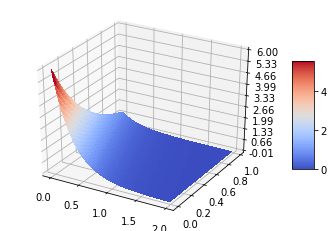

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [20]:
# Save Model
torch.save(net.state_dict(), "model_uxt.pt")